In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import warnings
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

Reading file: clean_train_data.csv
Successfully read file!
Reading file: clean_val_data.csv
Successfully read file!


In [3]:
from src.utils import get_config

In [4]:
config = get_config.read_yaml_from_main()
print("Configuration loaded successfully!")

Configuration loaded successfully!


In [5]:
# --- Add this to a new cell in your notebook ---
import optuna
from sklearn.metrics import average_precision_score

def objective(trial, model_name):
    """A general objective function to tune different models."""

    # Step 1: Suggest hyperparameters based on the model name
    if model_name == 'lightgbm':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
            'class_weight': 'balanced', 'random_state': 42, 'verbose': -1
        }
        model_class = lgb.LGBMClassifier

    elif model_name == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'eval_metric': 'logloss', 'random_state': 42
        }
        model_class = xgb.XGBClassifier

    elif model_name == 'catboost':
        params = {
            'iterations': trial.suggest_int('iterations', 200, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 4, 12),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'auto_class_weights': 'Balanced', 'random_state': 42, 'verbose': 0
        }
        model_class = cb.CatBoostClassifier
    else:
        # Return a very low value if the model name is not tunable with this function
        return -1.0

    # Step 2: Load data (this part is the same)
    data_dir = config['paths']['processed_data_directory']
    train_df = pd.read_csv(data_dir + "/clean_train_data.csv")
    val_df = pd.read_csv(data_dir + "/clean_val_data.csv")
    id_col, target_col = config['data']['id'], config['data']['target']
    X_train, y_train = train_df.drop(columns=[id_col, target_col]), train_df[target_col]
    X_val, y_val = val_df.drop(columns=[id_col, target_col]), val_df[target_col]

    # Step 3: Train and evaluate the model
    model = model_class(**params)
    model.fit(X_train, y_train)
    val_preds = model.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, val_preds)

    return pr_auc

In [6]:
# --- Tune LightGBM ---
import xgboost as xgb  # <-- Add this line
import catboost as cb  # <-- Add this line
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(lambda trial: objective(trial, 'lightgbm'), n_trials=1)
best_params_lgbm = study_lgbm.best_params
print("Best LightGBM Params:", best_params_lgbm)

# --- Tune XGBoost ---
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: objective(trial, 'xgboost'), n_trials=1)
best_params_xgb = study_xgb.best_params
print("Best XGBoost Params:", best_params_xgb)

# --- (Optional) Train your final model with the best params ---
# You would now modify your `train.py` to accept these `best_params`
# and pass them to the model class constructor.

[I 2025-09-01 04:29:25,558] A new study created in memory with name: no-name-95503033-674a-4e8f-b3c0-b5c902811a1a
[I 2025-09-01 04:29:36,552] Trial 0 finished with value: 0.10686201132878043 and parameters: {'n_estimators': 782, 'learning_rate': 0.1768735072945891, 'num_leaves': 27, 'max_depth': 12, 'lambda_l1': 0.027976261467259043, 'lambda_l2': 0.009230598956315943}. Best is trial 0 with value: 0.10686201132878043.
[I 2025-09-01 04:29:36,554] A new study created in memory with name: no-name-a3680fc8-6f1b-48cb-86cd-b0ed4902a310


Best LightGBM Params: {'n_estimators': 782, 'learning_rate': 0.1768735072945891, 'num_leaves': 27, 'max_depth': 12, 'lambda_l1': 0.027976261467259043, 'lambda_l2': 0.009230598956315943}


[I 2025-09-01 04:29:54,058] Trial 0 finished with value: 0.10658679899184781 and parameters: {'n_estimators': 1225, 'learning_rate': 0.1103759171964545, 'max_depth': 10, 'subsample': 0.7329134910442706, 'colsample_bytree': 0.7390579758579559, 'gamma': 1.771194773449667}. Best is trial 0 with value: 0.10658679899184781.


Best XGBoost Params: {'n_estimators': 1225, 'learning_rate': 0.1103759171964545, 'max_depth': 10, 'subsample': 0.7329134910442706, 'colsample_bytree': 0.7390579758579559, 'gamma': 1.771194773449667}


In [7]:
import shap
import joblib
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

def explain_model(model_name, X_data):
    """
    Loads a saved model, creates SHAP explanations, and shows plots.
    This version robustly handles different SHAP output formats and improves plot readability.
    """
    print(f"--- Generating SHAP Explanations for: {model_name} ---")

    # 1. Load the saved model wrapper
    model_dir = Path(config['paths']['model_data_directory'])
    model_path = model_dir / f"{model_name}_model.joblib"
    try:
        wrapper_model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Model file not found at {model_path}. Skipping.")
        return

    actual_model = wrapper_model.model

    # 2. Create the appropriate SHAP explainer
    if model_name in ['lightgbm', 'xgboost', 'catboost']:
        explainer = shap.TreeExplainer(actual_model)
        shap_values = explainer.shap_values(X_data)

        # Check if shap_values is a list (standard for binary classification)
        if isinstance(shap_values, list):
            # If it's a list of two arrays, take the one for the positive class (class 1)
            shap_values_to_plot = shap_values[1]
        else:
            # If it's a single array, it's already the shap_values for the positive class
            shap_values_to_plot = shap_values

        # Handle both scalar and array cases for expected_value
        if isinstance(explainer.expected_value, (list, np.ndarray)):
            base_value = explainer.expected_value[1]
        else:
            base_value = explainer.expected_value

    elif model_name == 'logistic_regression':
        explainer = shap.LinearExplainer(actual_model, X_data)
        shap_values_to_plot = explainer.shap_values(X_data)
        base_value = explainer.expected_value
    else:
        print(f"SHAP explanation for '{model_name}' is not configured. Skipping.")
        return

    # 3. Generate and display plots
    shap.initjs()

    print("\n--- SHAP Summary Plot (Bar Chart) ---")
    # --- CHANGE FOR READABILITY ---
    # Create a larger figure and use a bar plot for clarity
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_to_plot, X_data, plot_type="bar")
    plt.show()
    # --- END CHANGE ---

    print("\n--- SHAP Force Plot for the first instance ---")
    display(shap.force_plot(base_value, shap_values_to_plot[0,:], X_data.iloc[0,:]))



In [8]:
    data_dir = config['paths']['processed_data_directory']
    train_df = pd.read_csv(data_dir + 'clean_train_data.csv')
    val_df = pd.read_csv(data_dir + "/clean_val_data.csv")

    # 2. Prepare Data
    id_col = config['data']['id']
    target_col = config['data']['target']

    X_train = train_df.drop(columns=[id_col, target_col])
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=[id_col, target_col])
    y_val = val_df[target_col]

--- Generating SHAP Explanations for: lightgbm ---



--- SHAP Summary Plot (Bar Chart) ---


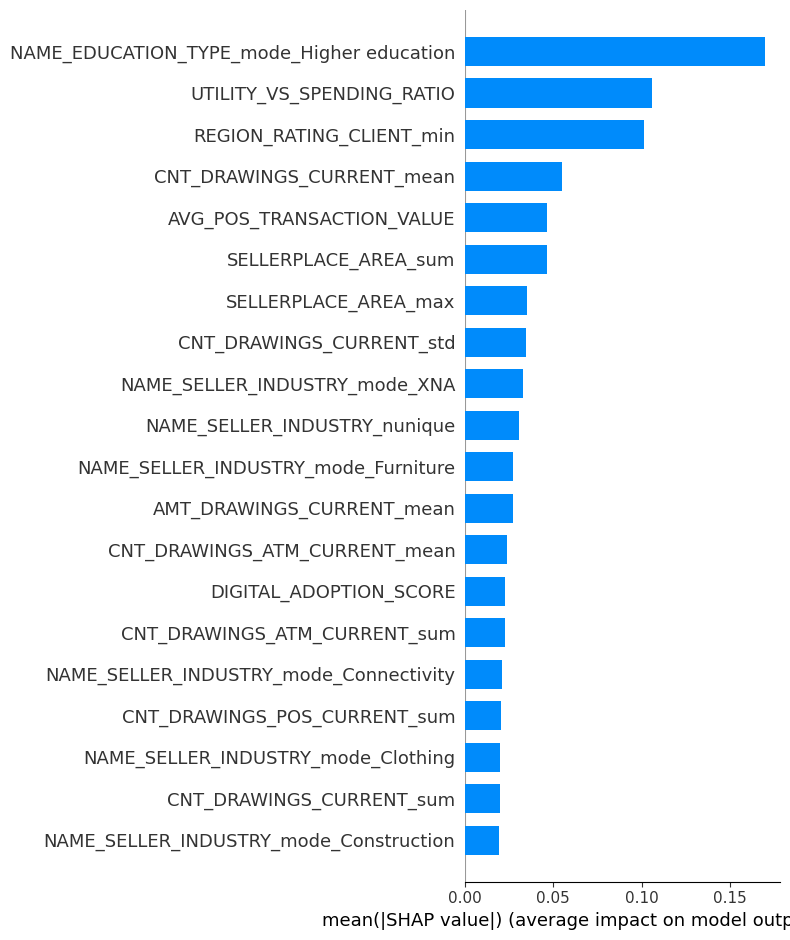


--- SHAP Force Plot for the first instance ---


In [9]:
explain_model("lightgbm", X_train)